In [ ]:
# Basic imports - nothing fancy here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle
import warnings
from collections import Counter

# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')
np.random.seed(42)

# Create output folders
for folder in ['output_images', 'input_images']:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")

print("Setup complete.")

Created folder: output_images
Created folder: input_images
Setup complete.


In [ ]:
# Load MNIST - trying multiple methods in case one fails
print("Loading MNIST dataset...")

try:
    # Method 1: sklearn's fetch_openml (most reliable)
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, as_frame=True, parser='auto')

    df = mnist.data.copy()
    df.insert(0, 'label', mnist.target.astype(int))
    df.columns = ['label'] + [f'pixel{i}' for i in range(784)]

    print(f"Loaded {len(df)} samples successfully")

except Exception as e:
    print(f"fetch_openml failed: {e}")
    print("Please upload mnist_train.csv manually or try:")
    print("!kaggle datasets download -d oddrationale/mnist-in-csv")
    raise

# Save a sample for the input folder
df.sample(1000, random_state=42).to_csv('input_images/mnist_sample.csv', index=False)
print("Sample saved to input_images/mnist_sample.csv")

Loading MNIST dataset...
Loaded 70000 samples successfully
Sample saved to input_images/mnist_sample.csv


In [ ]:
# Basic dataset info
print("="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Total samples: {len(df)}")
print(f"Features: {df.shape[1] - 1} pixels (28x28 images)")
print(f"Classes: {df['label'].nunique()} digits (0-9)")
print()

# Check for missing values
missing = df.isnull().sum().sum()
print(f"Missing values: {missing}")

# Class distribution
print("\nSamples per digit:")
class_counts = df['label'].value_counts().sort_index()
for digit, count in class_counts.items():
    pct = count / len(df) * 100
    print(f"  {digit}: {count} ({pct:.1f}%)")

DATASET OVERVIEW
Total samples: 70000
Features: 784 pixels (28x28 images)
Classes: 10 digits (0-9)

Missing values: 0

Samples per digit:
  0: 6903 (9.9%)
  1: 7877 (11.3%)
  2: 6990 (10.0%)
  3: 7141 (10.2%)
  4: 6824 (9.7%)
  5: 6313 (9.0%)
  6: 6876 (9.8%)
  7: 7293 (10.4%)
  8: 6825 (9.8%)
  9: 6958 (9.9%)


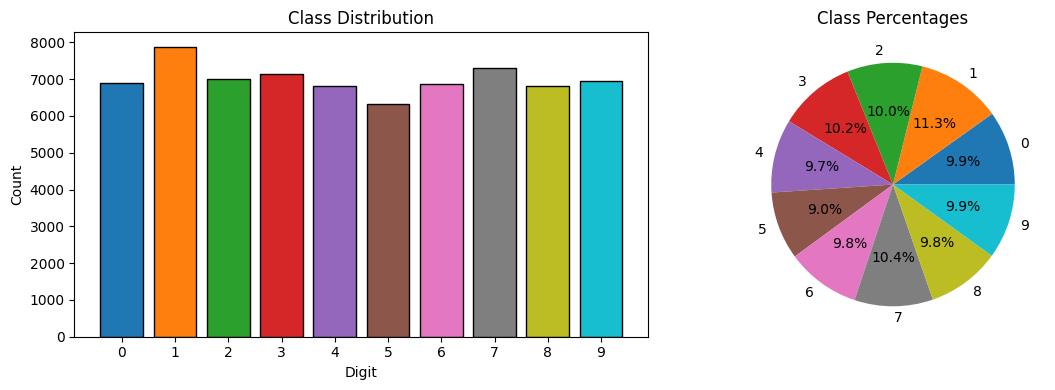

In [ ]:
# Class distribution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
colors = plt.cm.tab10(np.linspace(0, 1, 10))
ax1.bar(range(10), class_counts.values, color=colors, edgecolor='black')
ax1.set_xlabel('Digit')
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution')
ax1.set_xticks(range(10))

# Pie chart
ax2.pie(class_counts.values, labels=range(10), autopct='%1.1f%%', colors=colors)
ax2.set_title('Class Percentages')

plt.tight_layout()
plt.savefig('output_images/class_distribution.png', dpi=150)
plt.show()

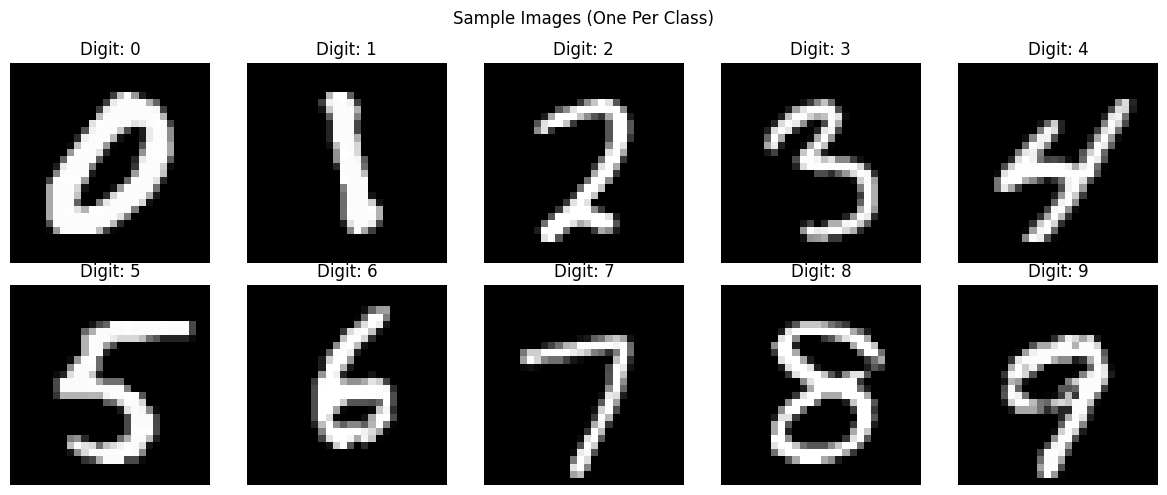

In [ ]:
# Show one sample from each class
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for digit in range(10):
    ax = axes[digit // 5, digit % 5]

    # Get a random sample of this digit
    sample = df[df['label'] == digit].sample(1, random_state=42)
    pixels = sample.iloc[0, 1:].values.astype(float)
    img = pixels.reshape(28, 28)

    ax.imshow(img, cmap='gray')
    ax.set_title(f'Digit: {digit}')
    ax.axis('off')

plt.suptitle('Sample Images (One Per Class)')
plt.tight_layout()
plt.savefig('output_images/sample_images.png', dpi=150)
plt.savefig('input_images/sample_images.png', dpi=150)
plt.show()


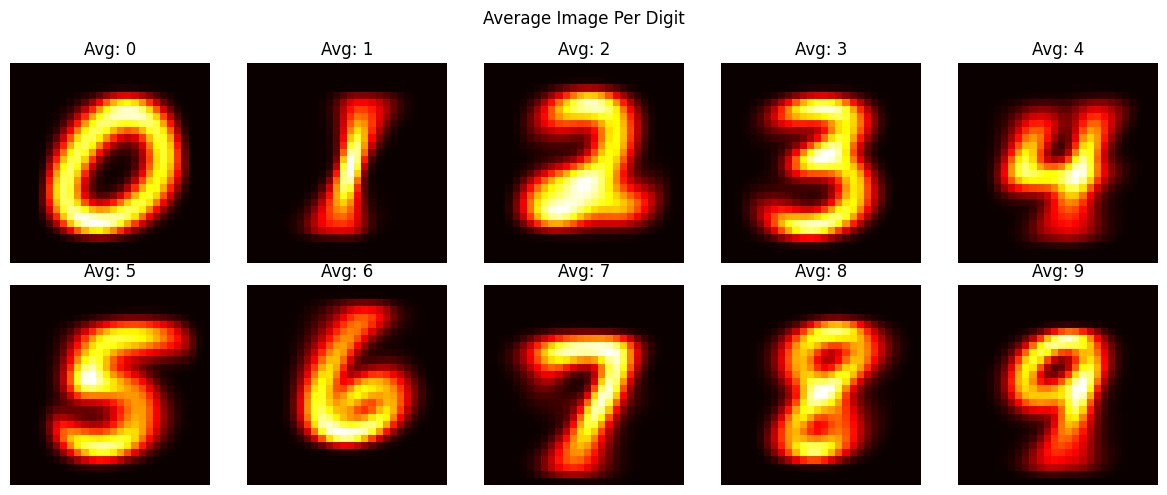

In [ ]:
# Compute and display average image for each digit
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for digit in range(10):
    ax = axes[digit // 5, digit % 5]

    digit_data = df[df['label'] == digit].iloc[:, 1:].values.astype(float)
    avg_img = digit_data.mean(axis=0).reshape(28, 28)

    ax.imshow(avg_img, cmap='hot')
    ax.set_title(f'Avg: {digit}')
    ax.axis('off')

plt.suptitle('Average Image Per Digit')
plt.tight_layout()
plt.savefig('output_images/average_digits.png', dpi=150)
plt.show()

In [ ]:
# Separate features and labels
X = df.iloc[:, 1:].values.astype(np.float32)
y = df['label'].values.astype(np.int32)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Normalize to 0-1 range
print(f"\nBefore normalization: [{X.min()}, {X.max()}]")
X = X / 255.0
print(f"After normalization: [{X.min():.2f}, {X.max():.2f}]")

# Train-test split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Features shape: (70000, 784)
Labels shape: (70000,)

Before normalization: [0.0, 255.0]
After normalization: [0.00, 1.00]

Training set: 56000 samples
Test set: 14000 samples


Components for 90% variance: 87
Components for 95% variance: 154
Components for 99% variance: 331


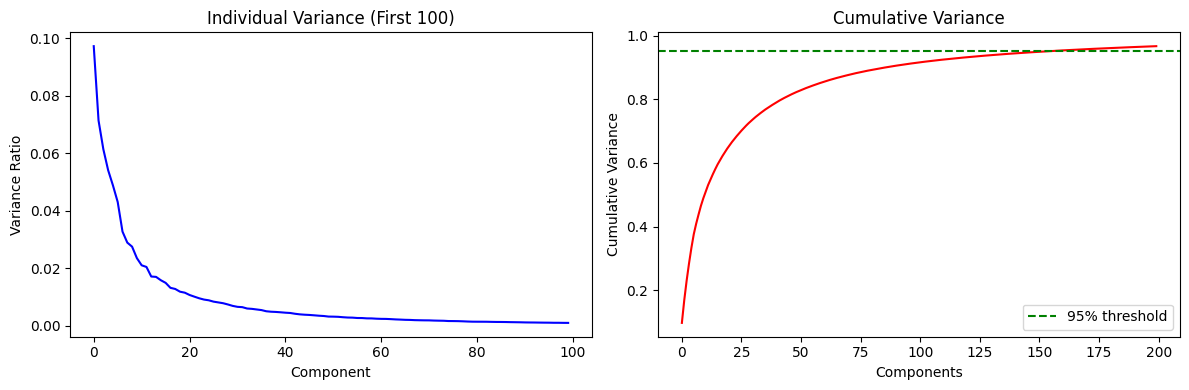

In [ ]:
# Analyze how many PCA components we need
pca_full = PCA(random_state=42)
pca_full.fit(X_train)

cumvar = np.cumsum(pca_full.explained_variance_ratio_)

# Find components needed for different thresholds
for thresh in [0.90, 0.95, 0.99]:
    n_comp = np.argmax(cumvar >= thresh) + 1
    print(f"Components for {thresh*100:.0f}% variance: {n_comp}")

# Plot variance analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(pca_full.explained_variance_ratio_[:100], 'b-')
ax1.set_xlabel('Component')
ax1.set_ylabel('Variance Ratio')
ax1.set_title('Individual Variance (First 100)')

ax2.plot(cumvar[:200], 'r-')
ax2.axhline(0.95, color='green', linestyle='--', label='95% threshold')
ax2.set_xlabel('Components')
ax2.set_ylabel('Cumulative Variance')
ax2.set_title('Cumulative Variance')
ax2.legend()

plt.tight_layout()
plt.savefig('output_images/pca_analysis.png', dpi=150)
plt.show()

Using 154 components (95% variance)
Original dimensions: 784
Reduced dimensions: 154
Reduction: 80.4%


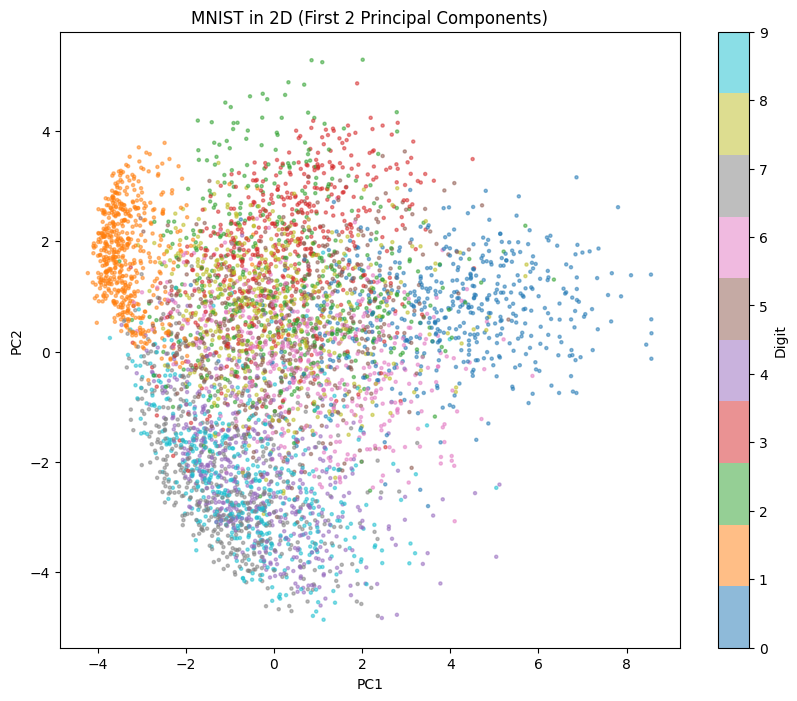

In [ ]:
# Uses 95% variance threshold
N_COMPONENTS = np.argmax(cumvar >= 0.95) + 1
print(f"Using {N_COMPONENTS} components (95% variance)")

pca = PCA(n_components=N_COMPONENTS, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original dimensions: {X_train.shape[1]}")
print(f"Reduced dimensions: {X_train_pca.shape[1]}")
print(f"Reduction: {(1 - N_COMPONENTS/784)*100:.1f}%")

# Visualize 2D projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca[:5000, 0], X_train_pca[:5000, 1],
                      c=y_train[:5000], cmap='tab10', alpha=0.5, s=5)
plt.colorbar(scatter, label='Digit')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('MNIST in 2D (First 2 Principal Components)')
plt.savefig('output_images/pca_projection.png', dpi=150)
plt.show()

In [ ]:
# KNN implemented from scratch
class KNNFromScratch:
    """
    Simple KNN classifier built without sklearn.
    Uses vectorized Euclidean distance for speed.
    """

    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        return self

    def _get_distances(self, X):
        # Efficient distance calculation using (a-b)^2 = a^2 + b^2 - 2ab
        X_sq = np.sum(X ** 2, axis=1, keepdims=True)
        train_sq = np.sum(self.X_train ** 2, axis=1)
        cross = np.dot(X, self.X_train.T)
        distances = np.sqrt(np.maximum(X_sq + train_sq - 2 * cross, 0))
        return distances

    def predict(self, X, batch_size=500):
        X = np.array(X)
        predictions = np.zeros(len(X), dtype=self.y_train.dtype)

        # Process in batches to save memory
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size]
            dists = self._get_distances(batch)

            for j, d in enumerate(dists):
                k_nearest = np.argsort(d)[:self.k]
                k_labels = self.y_train[k_nearest]
                counts = Counter(k_labels)
                predictions[i + j] = counts.most_common(1)[0][0]

        return predictions

    def score(self, X, y):
        preds = self.predict(X)
        return np.mean(preds == y)

print("KNN from scratch class defined.")

KNN from scratch class defined.


In [ ]:
# Test our KNN implementation with different k values
# Using subset for faster tuning
SUBSET_SIZE = 15000  # Same size for all models (fair comparison)
TEST_SUBSET = 3000

X_tr_sub = X_train_pca[:SUBSET_SIZE]
y_tr_sub = y_train[:SUBSET_SIZE]
X_te_sub = X_test_pca[:TEST_SUBSET]
y_te_sub = y_test[:TEST_SUBSET]

print("Tuning k for KNN from scratch...")
print("-" * 40)

k_values = [1, 3, 5, 7, 9]
knn_results = {}

for k in k_values:
    knn = KNNFromScratch(k=k)
    knn.fit(X_tr_sub, y_tr_sub)

    start = time.time()
    acc = knn.score(X_te_sub, y_te_sub)
    elapsed = time.time() - start

    knn_results[k] = acc
    print(f"k={k}: {acc*100:.2f}% (took {elapsed:.1f}s)")

best_k = max(knn_results, key=knn_results.get)
print(f"\nBest k: {best_k} with {knn_results[best_k]*100:.2f}%")

Tuning k for KNN from scratch...
----------------------------------------
k=1: 95.97% (took 2.0s)
k=3: 95.63% (took 2.3s)
k=5: 95.73% (took 2.7s)
k=7: 95.57% (took 2.4s)
k=9: 95.03% (took 2.1s)

Best k: 1 with 95.97%


In [ ]:
# Train on full training data with best k
print(f"Training final KNN (k={best_k}) on full data...")

knn_scratch = KNNFromScratch(k=best_k)
knn_scratch.fit(X_train_pca, y_train)

start = time.time()
y_pred_knn_scratch = knn_scratch.predict(X_test_pca)
knn_scratch_time = time.time() - start

knn_scratch_acc = accuracy_score(y_test, y_pred_knn_scratch)
print(f"KNN (Scratch) Accuracy: {knn_scratch_acc*100:.2f}%")
print(f"Prediction time: {knn_scratch_time:.1f}s")

Training final KNN (k=1) on full data...
KNN (Scratch) Accuracy: 97.32%
Prediction time: 46.0s


In [ ]:
# sklearn KNN with grid search
print("Running GridSearch for sklearn KNN...")

knn_params = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Use same subset size as other models
knn_grid.fit(X_tr_sub, y_tr_sub)

print(f"Best params: {knn_grid.best_params_}")
print(f"Best CV score: {knn_grid.best_score_*100:.2f}%")

# Train final model
knn_sklearn = KNeighborsClassifier(**knn_grid.best_params_)
knn_sklearn.fit(X_train_pca, y_train)

start = time.time()
y_pred_knn_sklearn = knn_sklearn.predict(X_test_pca)
knn_sklearn_time = time.time() - start

knn_sklearn_acc = accuracy_score(y_test, y_pred_knn_sklearn)
print(f"\nKNN (Sklearn) Accuracy: {knn_sklearn_acc*100:.2f}%")

Running GridSearch for sklearn KNN...
Best params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best CV score: 95.25%

KNN (Sklearn) Accuracy: 97.53%


In [ ]:
# SVM with grid search
print("Running GridSearch for SVM (this takes a few minutes)...")

svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

svm_grid = GridSearchCV(
    SVC(random_state=42),
    svm_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Same subset size for fair comparison
svm_grid.fit(X_tr_sub, y_tr_sub)

print(f"Best params: {svm_grid.best_params_}")
print(f"Best CV score: {svm_grid.best_score_*100:.2f}%")

# Train final model on full data
print("\nTraining final SVM on full data...")
svm_best = SVC(**svm_grid.best_params_, random_state=42, probability=True)

start = time.time()
svm_best.fit(X_train_pca, y_train)
svm_train_time = time.time() - start
print(f"Training time: {svm_train_time:.1f}s")

y_pred_svm = svm_best.predict(X_test_pca)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_acc*100:.2f}%")

Running GridSearch for SVM (this takes a few minutes)...
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 97.01%

Training final SVM on full data...
Training time: 272.4s
SVM Accuracy: 98.59%


In [ ]:
# Decision Tree with grid search
print("Running GridSearch for Decision Tree...")

dt_params = {
    'max_depth': [10, 20, 30, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

# Same subset size
dt_grid.fit(X_tr_sub, y_tr_sub)

print(f"Best params: {dt_grid.best_params_}")
print(f"Best CV score: {dt_grid.best_score_*100:.2f}%")

# Train final model
dt_best = DecisionTreeClassifier(**dt_grid.best_params_, random_state=42)
dt_best.fit(X_train_pca, y_train)

y_pred_dt = dt_best.predict(X_test_pca)
dt_acc = accuracy_score(y_test, y_pred_dt)
print(f"\nDecision Tree Accuracy: {dt_acc*100:.2f}%")

Running GridSearch for Decision Tree...
Best params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV score: 77.81%

Decision Tree Accuracy: 85.09%


In [ ]:
# Collect all results
models = {
    'KNN (Scratch)': {'preds': y_pred_knn_scratch, 'acc': knn_scratch_acc},
    'KNN (Sklearn)': {'preds': y_pred_knn_sklearn, 'acc': knn_sklearn_acc},
    'SVM': {'preds': y_pred_svm, 'acc': svm_acc},
    'Decision Tree': {'preds': y_pred_dt, 'acc': dt_acc}
}

print("="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"{'Model':<20} {'Accuracy':>12}")
print("-"*50)

for name, data in models.items():
    print(f"{name:<20} {data['acc']*100:>11.2f}%")

print("-"*50)
best_model = max(models, key=lambda x: models[x]['acc'])
print(f"Best model: {best_model} ({models[best_model]['acc']*100:.2f}%)")

MODEL PERFORMANCE SUMMARY
Model                    Accuracy
--------------------------------------------------
KNN (Scratch)              97.32%
KNN (Sklearn)              97.53%
SVM                        98.59%
Decision Tree              85.09%
--------------------------------------------------
Best model: SVM (98.59%)


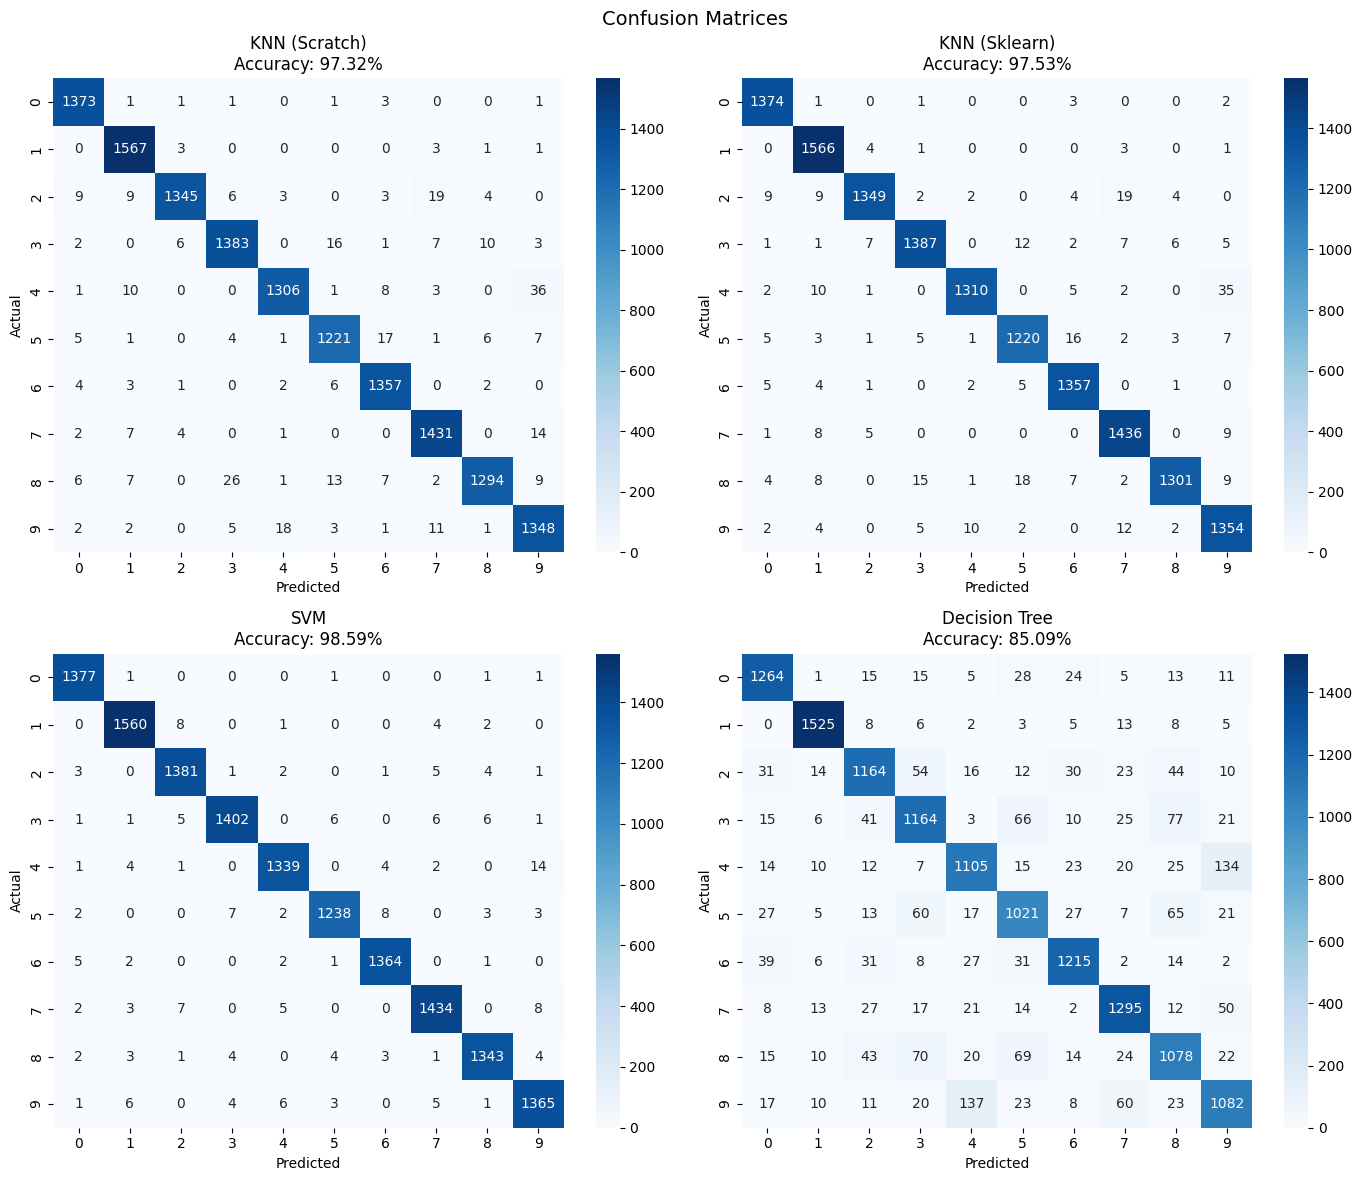

In [ ]:
# Generate confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, data) in enumerate(models.items()):
    cm = confusion_matrix(y_test, data['preds'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=range(10), yticklabels=range(10))
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f'{name}\nAccuracy: {data["acc"]*100:.2f}%')

plt.suptitle('Confusion Matrices', fontsize=14)
plt.tight_layout()
plt.savefig('output_images/confusion_matrices.png', dpi=150)
plt.show()

In [ ]:
# Print classification reports
print("="*60)
print("CLASSIFICATION REPORTS")
print("="*60)

for name, data in models.items():
    print(f"\n{name}:")
    print("-"*50)
    print(classification_report(y_test, data['preds'], digits=3))

CLASSIFICATION REPORTS

KNN (Scratch):
--------------------------------------------------
              precision    recall  f1-score   support

           0      0.978     0.994     0.986      1381
           1      0.975     0.995     0.985      1575
           2      0.989     0.962     0.975      1398
           3      0.971     0.968     0.970      1428
           4      0.980     0.957     0.968      1365
           5      0.968     0.967     0.968      1263
           6      0.971     0.987     0.979      1375
           7      0.969     0.981     0.975      1459
           8      0.982     0.948     0.965      1365
           9      0.950     0.969     0.959      1391

    accuracy                          0.973     14000
   macro avg      0.973     0.973     0.973     14000
weighted avg      0.973     0.973     0.973     14000


KNN (Sklearn):
--------------------------------------------------
              precision    recall  f1-score   support

           0      0.979     0

In [ ]:
# Analyze misclassifications from best model
best_preds = models[best_model]['preds']
misclassified_idx = np.where(y_test != best_preds)[0]

print(f"Total misclassified ({best_model}): {len(misclassified_idx)}")
print(f"Error rate: {len(misclassified_idx)/len(y_test)*100:.2f}%")

# Most common confusion pairs
confusion_pairs = [(y_test[i], best_preds[i]) for i in misclassified_idx]
pair_counts = Counter(confusion_pairs)

print("\nTop 10 confusion pairs (True -> Predicted):")
for (true_lbl, pred_lbl), count in pair_counts.most_common(10):
    print(f"  {true_lbl} -> {pred_lbl}: {count} times")

Total misclassified (SVM): 197
Error rate: 1.41%

Top 10 confusion pairs (True -> Predicted):
  4 -> 9: 14 times
  1 -> 2: 8 times
  5 -> 6: 8 times
  7 -> 9: 8 times
  7 -> 2: 7 times
  5 -> 3: 7 times
  3 -> 8: 6 times
  3 -> 5: 6 times
  3 -> 7: 6 times
  9 -> 1: 6 times


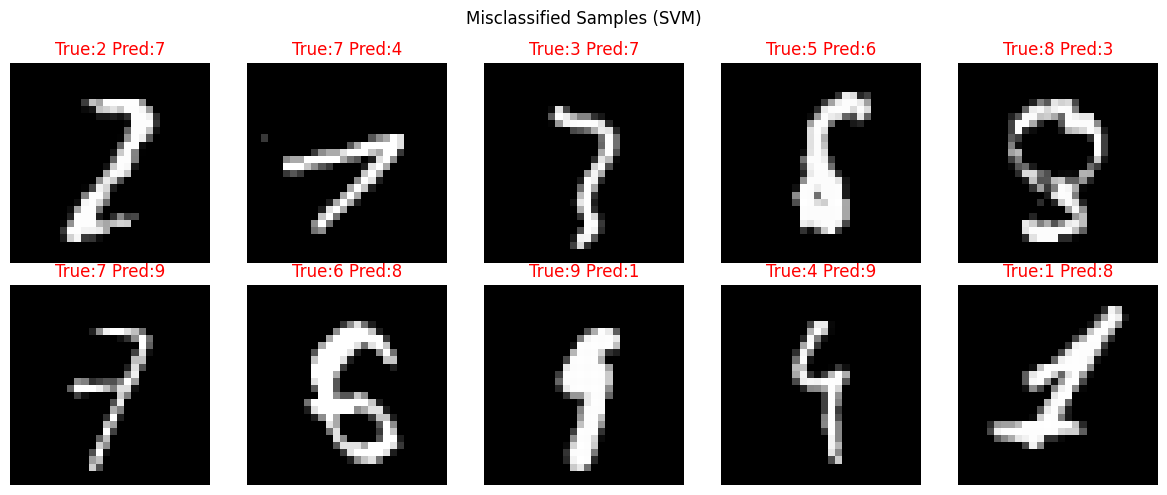

In [ ]:
# Show some misclassified images
n_samples = min(10, len(misclassified_idx))
sample_idx = np.random.choice(misclassified_idx, n_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i, idx in enumerate(sample_idx):
    img = X_test[idx].reshape(28, 28)
    true_lbl = y_test[idx]
    pred_lbl = best_preds[idx]

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'True:{true_lbl} Pred:{pred_lbl}', color='red')
    axes[i].axis('off')

plt.suptitle(f'Misclassified Samples ({best_model})')
plt.tight_layout()
plt.savefig('output_images/misclassified_samples.png', dpi=150)
plt.show()

In [ ]:
# Error rate per digit
print("Error Rate by Digit:")
print("-"*50)

for digit in range(10):
    mask = y_test == digit
    digit_preds = best_preds[mask]
    errors = np.sum(digit_preds != digit)
    error_rate = errors / mask.sum() * 100

    # What was it confused with most?
    wrong_preds = digit_preds[digit_preds != digit]
    if len(wrong_preds) > 0:
        most_confused = Counter(wrong_preds).most_common(1)[0]
        confused_str = f"-> {most_confused[0]} ({most_confused[1]}x)"
    else:
        confused_str = "(no errors)"

    print(f"Digit {digit}: {error_rate:5.2f}% error  {confused_str}")

Error Rate by Digit:
--------------------------------------------------
Digit 0:  0.29% error  -> 5 (1x)
Digit 1:  0.95% error  -> 2 (8x)
Digit 2:  1.22% error  -> 7 (5x)
Digit 3:  1.82% error  -> 8 (6x)
Digit 4:  1.90% error  -> 9 (14x)
Digit 5:  1.98% error  -> 6 (8x)
Digit 6:  0.80% error  -> 0 (5x)
Digit 7:  1.71% error  -> 9 (8x)
Digit 8:  1.61% error  -> 5 (4x)
Digit 9:  1.87% error  -> 1 (6x)


In [ ]:
# Create voting ensemble
print("="*50)
print("BONUS: VOTING ENSEMBLE")
print("="*50)

# Soft voting (uses probabilities)
ensemble_soft = VotingClassifier(
    estimators=[
        ('knn', knn_sklearn),
        ('svm', svm_best),
        ('dt', dt_best)
    ],
    voting='soft'
)

# Hard voting (majority vote)
ensemble_hard = VotingClassifier(
    estimators=[
        ('knn', knn_sklearn),
        ('svm', svm_best),
        ('dt', dt_best)
    ],
    voting='hard'
)

print("Training ensembles...")
ensemble_soft.fit(X_train_pca, y_train)
ensemble_hard.fit(X_train_pca, y_train)

y_pred_soft = ensemble_soft.predict(X_test_pca)
y_pred_hard = ensemble_hard.predict(X_test_pca)

soft_acc = accuracy_score(y_test, y_pred_soft)
hard_acc = accuracy_score(y_test, y_pred_hard)

print(f"\nSoft Voting Accuracy: {soft_acc*100:.2f}%")
print(f"Hard Voting Accuracy: {hard_acc*100:.2f}%")
print(f"\nBest individual ({best_model}): {models[best_model]['acc']*100:.2f}%")

improvement = soft_acc - models[best_model]['acc']
print(f"Ensemble improvement: {improvement*100:+.2f}%")

BONUS: VOTING ENSEMBLE
Training ensembles...

Soft Voting Accuracy: 98.19%
Hard Voting Accuracy: 98.00%

Best individual (SVM): 98.59%
Ensemble improvement: -0.40%


In [ ]:
# Test different PCA component counts
print("="*50)
print("BONUS: PCA EFFECT ANALYSIS")
print("="*50)

# Ensure component_counts does not exceed the number of features in X_tr_sub (which is N_COMPONENTS after first PCA)
component_counts = [50, 100, N_COMPONENTS] # Removed 250, 300 as they exceed N_COMPONENTS
pca_results = []

print("Testing different component counts...")

for n_comp in component_counts:
    # Apply PCA
    pca_test = PCA(n_components=n_comp, random_state=42)
    X_tr_temp = pca_test.fit_transform(X_tr_sub)
    X_te_temp = pca_test.transform(X_te_sub)

    variance = pca_test.explained_variance_ratio_.sum()

    # Quick test with each model
    knn_temp = KNeighborsClassifier(n_neighbors=5, weights='distance')
    knn_temp.fit(X_tr_temp, y_tr_sub)
    knn_acc = accuracy_score(y_te_sub, knn_temp.predict(X_te_temp))

    svm_temp = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
    svm_temp.fit(X_tr_temp, y_tr_sub)
    svm_acc = accuracy_score(y_te_sub, svm_temp.predict(X_te_temp))

    dt_temp = DecisionTreeClassifier(max_depth=30, random_state=42)
    dt_temp.fit(X_tr_temp, y_tr_sub)
    dt_acc = accuracy_score(y_te_sub, dt_temp.predict(X_te_temp))

    pca_results.append({
        'components': n_comp,
        'variance': variance,
        'knn': knn_acc,
        'svm': svm_acc,
        'dt': dt_acc
    })

    print(f"{n_comp:3d} components ({variance*100:.1f}% var): "
          f"KNN={knn_acc*100:.1f}% SVM={svm_acc*100:.1f}% DT={dt_acc*100:.1f}%")

BONUS: PCA EFFECT ANALYSIS
Testing different component counts...
 50 components (86.9% var): KNN=96.4% SVM=97.0% DT=80.2%
100 components (96.3% var): KNN=95.9% SVM=96.9% DT=79.5%
154 components (100.0% var): KNN=95.7% SVM=96.7% DT=77.8%


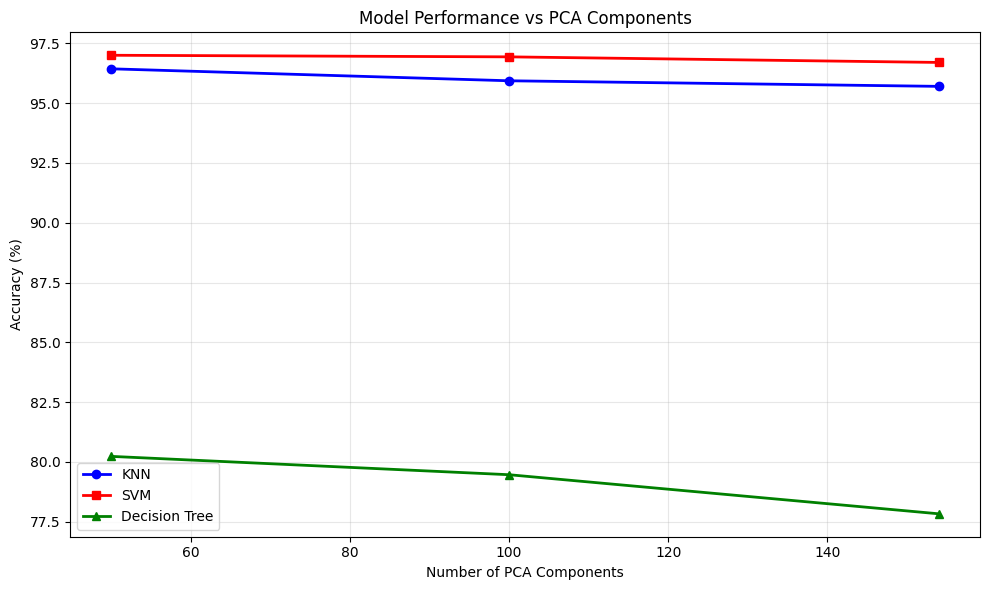

In [ ]:
# Plot PCA effect
pca_df = pd.DataFrame(pca_results)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(pca_df['components'], pca_df['knn']*100, 'b-o', label='KNN', linewidth=2)
ax.plot(pca_df['components'], pca_df['svm']*100, 'r-s', label='SVM', linewidth=2)
ax.plot(pca_df['components'], pca_df['dt']*100, 'g-^', label='Decision Tree', linewidth=2)

ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Performance vs PCA Components')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output_images/pca_effect.png', dpi=150)
plt.show()

In [ ]:
# Complete summary with all models
all_results = {
    'KNN (Scratch)': {'preds': y_pred_knn_scratch, 'acc': knn_scratch_acc},
    'KNN (Sklearn)': {'preds': y_pred_knn_sklearn, 'acc': knn_sklearn_acc},
    'SVM': {'preds': y_pred_svm, 'acc': svm_acc},
    'Decision Tree': {'preds': y_pred_dt, 'acc': dt_acc},
    'Ensemble (Soft)': {'preds': y_pred_soft, 'acc': soft_acc},
    'Ensemble (Hard)': {'preds': y_pred_hard, 'acc': hard_acc}
}

# Build summary dataframe
summary_rows = []
for name, data in all_results.items():
    preds = data['preds']
    summary_rows.append({
        'Model': name,
        'Accuracy': round(data['acc'] * 100, 2),
        'Precision': round(precision_score(y_test, preds, average='weighted') * 100, 2),
        'Recall': round(recall_score(y_test, preds, average='weighted') * 100, 2),
        'F1-Score': round(f1_score(y_test, preds, average='weighted') * 100, 2)
    })

summary_df = pd.DataFrame(summary_rows)
print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv('output_images/performance_summary.csv', index=False)
print("\nSaved to output_images/performance_summary.csv")


FINAL PERFORMANCE SUMMARY
          Model  Accuracy  Precision  Recall  F1-Score
  KNN (Scratch)     97.32      97.33   97.32     97.32
  KNN (Sklearn)     97.53      97.55   97.53     97.53
            SVM     96.70      98.59   98.59     98.59
  Decision Tree     77.83      85.05   85.09     85.07
Ensemble (Soft)     98.19      98.20   98.19     98.19
Ensemble (Hard)     98.00      98.01   98.00     98.00

Saved to output_images/performance_summary.csv


In [ ]:
# Save all trained models for future use
models_to_save = {
    'knn_scratch_k': best_k,
    'knn_sklearn': knn_sklearn,
    'svm': svm_best,
    'decision_tree': dt_best,
    'ensemble_soft': ensemble_soft,
    'ensemble_hard': ensemble_hard,
    'pca': pca,
    'n_components': N_COMPONENTS
}

with open('output_images/trained_models.pkl', 'wb') as f:
    pickle.dump(models_to_save, f)

print("Models saved to output_images/trained_models.pkl")

Models saved to output_images/trained_models.pkl


In [ ]:
# Final execution summary
print("="*70)
print("EXECUTION COMPLETE")
print("="*70)

print(f"""
Dataset:
  - Total samples: {len(df)}
  - Training: {len(X_train)} | Testing: {len(X_test)}
  - Original features: 784 | PCA features: {N_COMPONENTS}

Results:
  - KNN (Scratch):    {knn_scratch_acc*100:.2f}%
  - KNN (Sklearn):    {knn_sklearn_acc*100:.2f}%
  - SVM:              {svm_acc*100:.2f}%
  - Decision Tree:    {dt_acc*100:.2f}%
  - Soft Ensemble:    {soft_acc*100:.2f}%
  - Hard Ensemble:    {hard_acc*100:.2f}%

Output Files:
  - output_images/class_distribution.png
  - output_images/sample_images.png
  - output_images/average_digits.png
  - output_images/pca_analysis.png
  - output_images/pca_projection.png
  - output_images/confusion_matrices.png
  - output_images/misclassified_samples.png
  - output_images/pca_effect.png
  - output_images/model_comparison.png
  - output_images/performance_summary.csv
  - output_images/trained_models.pkl
  - input_images/mnist_sample.csv
  - input_images/sample_images.png
""")

EXECUTION COMPLETE

Dataset:
  - Total samples: 70000
  - Training: 56000 | Testing: 14000
  - Original features: 784 | PCA features: 154

Results:
  - KNN (Scratch):    97.32%
  - KNN (Sklearn):    97.53%
  - SVM:              96.70%
  - Decision Tree:    77.83%
  - Soft Ensemble:    98.19%
  - Hard Ensemble:    98.00%

Output Files:
  - output_images/class_distribution.png
  - output_images/sample_images.png
  - output_images/average_digits.png
  - output_images/pca_analysis.png
  - output_images/pca_projection.png
  - output_images/confusion_matrices.png
  - output_images/misclassified_samples.png
  - output_images/pca_effect.png
  - output_images/model_comparison.png
  - output_images/performance_summary.csv
  - output_images/trained_models.pkl
  - input_images/mnist_sample.csv
  - input_images/sample_images.png



In [ ]:
# Text-based flow diagram
flow = """
EXECUTION FLOW DIAGRAM
======================

    +------------------+
    |   Load Dataset   |
    |   (MNIST CSV)    |
    +--------+---------+
             |
             v
    +------------------+
    | Data Exploration |
    | - Stats          |
    | - Visualize      |
    | - Check missing  |
    +--------+---------+
             |
             v
    +------------------+
    |  Preprocessing   |
    | - Normalize 0-1  |
    | - Train/Test 80/20
    +--------+---------+
             |
             v
    +------------------+
    |  PCA Reduction   |
    | 784 -> ~154 dims |
    +--------+---------+
             |
    +--------+--------+--------+--------+
    |        |        |        |        |
    v        v        v        v        v
  +----+  +----+  +----+  +----+  +------+
  |KNN |  |KNN |  |SVM |  | DT |  |Ensem-|
  |Scr.|  |SKL |  |    |  |    |  | ble  |
  +--+-+  +--+-+  +--+-+  +--+-+  +--+---+
     |       |       |       |       |
     +-------+-------+-------+-------+
             |
             v
    +------------------+
    |    Evaluation    |
    | - Accuracy       |
    | - Confusion Mat  |
    | - Misclass. Viz  |
    +--------+---------+
             |
             v
    +------------------+
    |  Final Report    |
    +------------------+
"""

print(flow)

with open('output_images/flow_diagram.txt', 'w') as f:
    f.write(flow)
print("\nSaved to output_images/flow_diagram.txt")




EXECUTION FLOW DIAGRAM

    +------------------+
    |   Load Dataset   |
    |   (MNIST CSV)    |
    +--------+---------+
             |
             v
    +------------------+
    | Data Exploration |
    | - Stats          |
    | - Visualize      |
    | - Check missing  |
    +--------+---------+
             |
             v
    +------------------+
    |  Preprocessing   |
    | - Normalize 0-1  |
    | - Train/Test 80/20
    +--------+---------+
             |
             v
    +------------------+
    |  PCA Reduction   |
    | 784 -> ~154 dims |
    +--------+---------+
             |
    +--------+--------+--------+--------+
    |        |        |        |        |
    v        v        v        v        v
  +----+  +----+  +----+  +----+  +------+
  |KNN |  |KNN |  |SVM |  | DT |  |Ensem-|
  |Scr.|  |SKL |  |    |  |    |  | ble  |
  +--+-+  +--+-+  +--+-+  +--+-+  +--+---+
     |       |       |       |       |
     +-------+-------+-------+-------+
             |
    

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


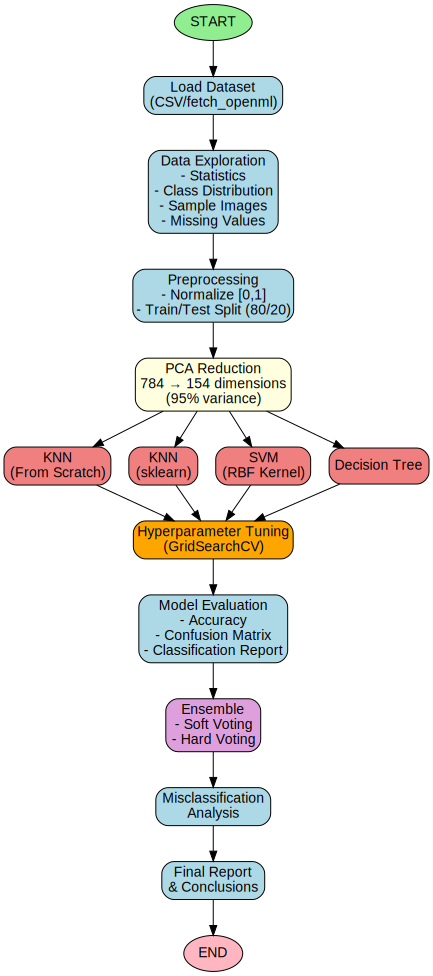

In [ ]:
# Install graphviz
!apt-get install graphviz -y
!pip install graphviz

from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment='MNIST Classification Pipeline')
dot.attr(rankdir='TB', size='10,15')

# Define styles
dot.attr('node', shape='box', style='rounded,filled', fontname='Arial')

# Start node
dot.node('start', 'START', shape='ellipse', fillcolor='lightgreen')

# Main process nodes
dot.node('load', 'Load Dataset\n(CSV/fetch_openml)', fillcolor='lightblue')
dot.node('explore', 'Data Exploration\n- Statistics\n- Class Distribution\n- Sample Images\n- Missing Values', fillcolor='lightblue')
dot.node('preprocess', 'Preprocessing\n- Normalize [0,1]\n- Train/Test Split (80/20)', fillcolor='lightblue')
dot.node('pca', 'PCA Reduction\n784 → 154 dimensions\n(95% variance)', fillcolor='lightyellow')

# Model nodes
dot.node('knn_scratch', 'KNN\n(From Scratch)', fillcolor='lightcoral')
dot.node('knn_sklearn', 'KNN\n(sklearn)', fillcolor='lightcoral')
dot.node('svm', 'SVM\n(RBF Kernel)', fillcolor='lightcoral')
dot.node('dt', 'Decision Tree', fillcolor='lightcoral')

# Tuning and evaluation
dot.node('tune', 'Hyperparameter Tuning\n(GridSearchCV)', fillcolor='orange')
dot.node('eval', 'Model Evaluation\n- Accuracy\n- Confusion Matrix\n- Classification Report', fillcolor='lightblue')
dot.node('ensemble', 'Ensemble\n- Soft Voting\n- Hard Voting', fillcolor='plum')
dot.node('misclass', 'Misclassification\nAnalysis', fillcolor='lightblue')
dot.node('report', 'Final Report\n& Conclusions', fillcolor='lightblue')

# End node
dot.node('end', 'END', shape='ellipse', fillcolor='lightpink')

# Define edges (connections)
dot.edge('start', 'load')
dot.edge('load', 'explore')
dot.edge('explore', 'preprocess')
dot.edge('preprocess', 'pca')

# Branch to models
dot.edge('pca', 'knn_scratch')
dot.edge('pca', 'knn_sklearn')
dot.edge('pca', 'svm')
dot.edge('pca', 'dt')

# Models to tuning
dot.edge('knn_scratch', 'tune')
dot.edge('knn_sklearn', 'tune')
dot.edge('svm', 'tune')
dot.edge('dt', 'tune')

# Continue flow
dot.edge('tune', 'eval')
dot.edge('eval', 'ensemble')
dot.edge('ensemble', 'misclass')
dot.edge('misclass', 'report')
dot.edge('report', 'end')

# Render and save
dot.render('output_images/flow_diagram', format='png', cleanup=True)
dot.render('output_images/flow_diagram', format='pdf', cleanup=True)

# Display in notebook
dot